# NOTE
1. Added a new function called take_step
2. Modified objective_function_wrapper

In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import seaborn           as sns
from matplotlib          import rcParams
from scipy.integrate     import odeint
from scipy.optimize      import basinhopping

plt.close('all')
sns.set_context('notebook')
rcParams['figure.facecolor'] = 'white'
rcParams['axes.facecolor']   = 'white'


## Define the Model

In [2]:
def model(y, t, ind, params):
    mRNA = y[0]
    prot = y[1]
    
    inducer = ind
    synm    = params[0]  
    k_ind   = params[1] 
    degm    = params[2] 
    synp    = params[3]
    mu      = params[4]
    
    dmRNA = synm*(inducer)/(inducer+k_ind)-degm*mRNA
    dprot = synp*mRNA-mu*prot
    
    return np.array([dmRNA, dprot])

## Plot Data

C:\Users\jingwui\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\jingwui\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


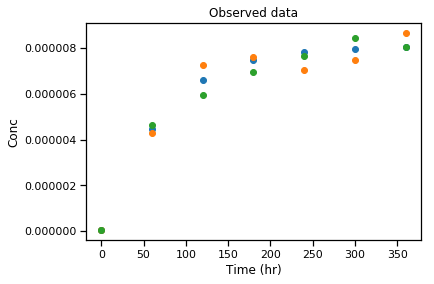

In [3]:
#Part 1: Produce a data set (evidence) and plot it
raw_data = pd.read_csv("Example_Data.csv")
tspan    = raw_data.iloc[:,0]
y_data   = raw_data.iloc[:,1:]

fig1 = plt.figure()
ax1  = fig1.add_subplot(1,1,1)
ax1.plot(tspan, y_data,'o')
setting = ax1.set(title='Observed data', xlabel='Time (hr)', ylabel='Conc')



## Integrating the Model

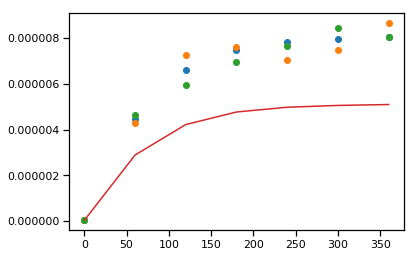

In [4]:
# Part 2: Integrate model using a set of parameters

y_init  = [0, 2.5e-8]
values  = {'synm'    : 2e-5,  
           'k_ind'   : 12, 
           'degm'    : 0.2,  
           'synp'    : 0.01,
           'mu'      : 0.015
          }
params     = list(values.values())
tspan= [0, 60, 120, 180, 240, 300, 360]
inducer = 1
model_data = odeint(model, y_init, tspan, args=tuple([inducer, params]))
y_model    = model_data[:,1]

fig2 = plt.figure()
ax2  = fig2.add_subplot(1,1,1)
ax2.plot(tspan, y_data,'o')
ax2.plot(tspan, y_model)
setting = ax1.set(title='Observed data', xlabel='Time (hr)', ylabel='Conc')

## Calculating Sum Squared Error

In [5]:
#Part 3: Calculate error

SSE = 0
for column in y_data:
    SSE += np.sum((y_data[column]-y_model)**2)

print(SSE)

1.2105899648847032e-10


## Wrap Process into a Function

In [6]:
def get_SSE(tspan, y_data, inducer, params):
    model_data = odeint(model, y_init, tspan, args=tuple([inducer, params]))
    y_model    = model_data[:,1]
    
    SSE = 0
    for column in y_data:
        SSE += np.sum((y_data[column]-y_model)**2)
    
    return SSE
    

In [7]:
print(get_SSE(tspan, y_data, inducer, params))

1.2105899648847032e-10


## Optimization Function

We will be using scipy's basinhopping algorithm for this problem, which seeks the minimum of an objective function. Since our goal is to minimize the SSE, our objective function is simply get_SSE. However, the documentation of the algorithm only allows the objective function to take in one argument. In addition, we already know the inducer concentration so we want it to be fixed. We thus wrap get_SSE as shown below. 

In [8]:
def objective_function_wrapper(tspan, y_data, inducer):
    def helper(params):
        return get_SSE(tspan, y_data, inducer, params)
    return helper

In [9]:
#Step size
def take_step(params):
    delta      = np.random.rand(len(params)) -0.5
    new_params = params + delta*params
    
    return new_params


In [10]:
#Wrap get_SSE
objective_function = objective_function_wrapper(tspan, y_data, inducer)
#This function now takes in the params as the sole argument and returns the SSE.

values  = {'synm'   : 2e-5,  
           'k_ind'   : 12, 
           'degm'    : 0.2,  
           'synp'    : 0.01,
           'mu'      : 0.015
          }
params     = list(values.values())


#Run optimizer.
result = basinhopping(objective_function, x0=params, niter=200, disp=True, 
                      take_step=take_step)
print(result)

basinhopping step 0: f 2.72187e-12
basinhopping step 1: f 3.48091e-12 trial_f 3.48091e-12 accepted 1  lowest_f 2.72187e-12
basinhopping step 2: f 1.47424e-11 trial_f 1.47424e-11 accepted 1  lowest_f 2.72187e-12
basinhopping step 3: f 2.34128e-10 trial_f 2.34128e-10 accepted 1  lowest_f 2.72187e-12
basinhopping step 4: f 1.85176e-10 trial_f 1.85176e-10 accepted 1  lowest_f 2.72187e-12
basinhopping step 5: f 4.80774e-11 trial_f 4.80774e-11 accepted 1  lowest_f 2.72187e-12
basinhopping step 6: f 1.11287e-10 trial_f 1.11287e-10 accepted 1  lowest_f 2.72187e-12
basinhopping step 7: f 4.02825e-11 trial_f 4.02825e-11 accepted 1  lowest_f 2.72187e-12
basinhopping step 8: f 4.14819e-10 trial_f 4.14819e-10 accepted 1  lowest_f 2.72187e-12
basinhopping step 9: f 3.48625e-10 trial_f 3.48625e-10 accepted 1  lowest_f 2.72187e-12
basinhopping step 10: f 5.92607e-10 trial_f 5.92607e-10 accepted 1  lowest_f 2.72187e-12
basinhopping step 11: f 9.80621e-11 trial_f 9.80621e-11 accepted 1  lowest_f 2.72187

basinhopping step 97: f 1.96547e-10 trial_f 1.96547e-10 accepted 1  lowest_f 2.72187e-12
basinhopping step 98: f 1.84131e-10 trial_f 1.84131e-10 accepted 1  lowest_f 2.72187e-12
basinhopping step 99: f 1.88269e-10 trial_f 1.88269e-10 accepted 1  lowest_f 2.72187e-12
basinhopping step 100: f 1.97181e-10 trial_f 1.97181e-10 accepted 1  lowest_f 2.72187e-12
basinhopping step 101: f 2.12389e-10 trial_f 2.12389e-10 accepted 1  lowest_f 2.72187e-12
basinhopping step 102: f 2.06026e-10 trial_f 2.06026e-10 accepted 1  lowest_f 2.72187e-12
basinhopping step 103: f 2.2277e-10 trial_f 2.2277e-10 accepted 1  lowest_f 2.72187e-12
basinhopping step 104: f 2.19065e-10 trial_f 2.19065e-10 accepted 1  lowest_f 2.72187e-12
basinhopping step 105: f 2.21494e-10 trial_f 2.21494e-10 accepted 1  lowest_f 2.72187e-12
basinhopping step 106: f 2.22519e-10 trial_f 2.22519e-10 accepted 1  lowest_f 2.72187e-12
basinhopping step 107: f 2.27439e-10 trial_f 2.27439e-10 accepted 1  lowest_f 2.72187e-12
basinhopping st

basinhopping step 191: f 2.47411e-10 trial_f 2.47411e-10 accepted 1  lowest_f 2.72187e-12
basinhopping step 192: f 2.45178e-10 trial_f 2.45178e-10 accepted 1  lowest_f 2.72187e-12
basinhopping step 193: f 2.45245e-10 trial_f 2.45245e-10 accepted 1  lowest_f 2.72187e-12
basinhopping step 194: f 2.44976e-10 trial_f 2.44976e-10 accepted 1  lowest_f 2.72187e-12
basinhopping step 195: f 2.4488e-10 trial_f 2.4488e-10 accepted 1  lowest_f 2.72187e-12
basinhopping step 196: f 2.49753e-10 trial_f 2.49753e-10 accepted 1  lowest_f 2.72187e-12
basinhopping step 197: f 2.47556e-10 trial_f 2.47556e-10 accepted 1  lowest_f 2.72187e-12
basinhopping step 198: f 2.4941e-10 trial_f 2.4941e-10 accepted 1  lowest_f 2.72187e-12
basinhopping step 199: f 2.44765e-10 trial_f 2.44765e-10 accepted 1  lowest_f 2.72187e-12
basinhopping step 200: f 2.47283e-10 trial_f 2.47283e-10 accepted 1  lowest_f 2.72187e-12
                        fun: 2.7218661246791656e-12
 lowest_optimization_result:       fun: 2.7218661246

In [11]:
best_value  = result.fun
best_params = list(result.x)
print(best_params)

[3.1339572594856627e-05, 11.999999999987683, 0.19999999933476564, 0.01000001342660098, 0.014999991521833612]


## Check the Result

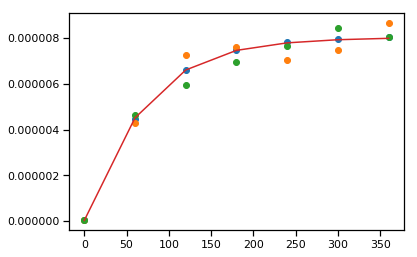

In [12]:
model_data = odeint(model, y_init, tspan, args=tuple([inducer, best_params]))
y_model    = model_data[:,1]

fig3 = plt.figure()
ax3  = fig3.add_subplot(1,1,1)
ax3.plot(tspan, y_data,'o')
ax3.plot(tspan, y_model)
setting = ax1.set(title='Observed data', xlabel='Time (hr)', ylabel='Conc')

In [13]:
#True parameter values
answer = { 'synm'    : 1e-5,  
           'k_ind'   : 10, 
           'degm'    : 0.15,  
           'synp'    : 0.02,
           'mu'      : 0.015
          }


## Assignment


1. Use a different model. 
    - Suppose we want to simplify the model into a one-step process i.e. protein synthesis is directly controlled by the inducer with no mRNA involved. Write your own model function and repeat the steps above using your model.
    - Suppose we want to model gene expression as a two-step process plus one maturation step i.e. protein synthesis is followed by a first order maturation step. Write your own model function and repeat the steps above using your model.

2. Use a different optimizer.
    - Suppose we want to use differential evolution for curve-fitting. Repeat the steps above using scipy's differential evolution optimizer.

3. Test your understanding
    - Why do we use sum squared error instead of simply summing up the errors directly?
    - Suppose we use an optimizer that searches for the maximum value of an objective function. Do we need to change the objective function? If so, how should we change it?

4. Analyze the results
    - The true parameters used to generate the data are shown in the cell above. Does your simulations always converge to the true parameters? Why? What are the underlying factors? How can we ensure that we can determine the true parameters? Does it always matter if we cannot determine the true parameters? (300 words)

## Solutions

basinhopping step 0: f 3.00422e-12
basinhopping step 1: f 2.68623e-12 trial_f 2.68623e-12 accepted 1  lowest_f 2.68623e-12
found new global minimum on step 1 with function value 2.68623e-12
basinhopping step 2: f 6.36363e-12 trial_f 6.36363e-12 accepted 1  lowest_f 2.68623e-12
basinhopping step 3: f 1.09121e-11 trial_f 1.09121e-11 accepted 1  lowest_f 2.68623e-12
basinhopping step 4: f 2.39733e-11 trial_f 2.39733e-11 accepted 1  lowest_f 2.68623e-12
basinhopping step 5: f 1.87735e-11 trial_f 1.87735e-11 accepted 1  lowest_f 2.68623e-12
basinhopping step 6: f 1.0878e-11 trial_f 1.0878e-11 accepted 1  lowest_f 2.68623e-12
basinhopping step 7: f 9.47851e-12 trial_f 9.47851e-12 accepted 1  lowest_f 2.68623e-12
basinhopping step 8: f 1.3646e-11 trial_f 1.3646e-11 accepted 1  lowest_f 2.68623e-12
basinhopping step 9: f 9.546e-12 trial_f 9.546e-12 accepted 1  lowest_f 2.68623e-12
basinhopping step 10: f 1.13309e-11 trial_f 1.13309e-11 accepted 1  lowest_f 2.68623e-12
basinhopping step 11: f 1

basinhopping step 94: f 1.39534e-11 trial_f 1.39534e-11 accepted 1  lowest_f 2.68623e-12
basinhopping step 95: f 2.18109e-11 trial_f 2.18109e-11 accepted 1  lowest_f 2.68623e-12
basinhopping step 96: f 1.28688e-11 trial_f 1.28688e-11 accepted 1  lowest_f 2.68623e-12
basinhopping step 97: f 1.49269e-11 trial_f 1.49269e-11 accepted 1  lowest_f 2.68623e-12
basinhopping step 98: f 1.2938e-11 trial_f 1.2938e-11 accepted 1  lowest_f 2.68623e-12
basinhopping step 99: f 6.89691e-12 trial_f 6.89691e-12 accepted 1  lowest_f 2.68623e-12
basinhopping step 100: f 5.81339e-12 trial_f 5.81339e-12 accepted 1  lowest_f 2.68623e-12
Best optimized params: [8.41000405e-07 6.98301059e+00 1.30478303e-02]


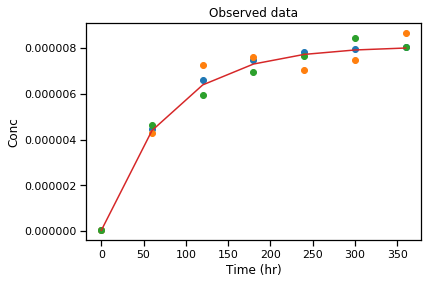

In [17]:
# Question 1a: 
def model_singleEqn(y, t, ind, params):
    prot = y[0]
    
    inducer = ind
    synp    = params[0]
    k_ind   = params[1]  
    mu      = params[2]
    
    dprot = synp*(inducer)/(inducer+k_ind)-mu*prot
    
    return np.array([dprot])


values1  = {'synp'    : 2e-5,  
            'k_ind'   : 12, 
            'mu'      : 0.015
          }
params     = list(values1.values())

y_init  = [2.5e-8]

inducer = 1

def get_SSE(tspan, y_data, inducer, params):
    model_data = odeint(model_singleEqn, y_init, tspan, args=tuple([inducer, params]))
    y_model    = model_data[:,0]
    
    SSE = 0
    for column in y_data:
        SSE += np.sum((y_data[column]-y_model)**2)
    
    return SSE


def objective_function_wrapper(tspan, y_data, inducer):
    def helper(params):
        return get_SSE(tspan, y_data, inducer, params)
    return helper

#This function now takes in the params as the sole argument and returns the SSE.
objective_function = objective_function_wrapper(tspan, y_data, inducer)


#Run optimizer.
result = basinhopping(objective_function, x0=params, niter=100, disp=True, 
                      take_step=take_step)
best_params = list(result.x)
print('Best optimized params:', result.x)


model_data = odeint(model_singleEqn, y_init, tspan, args=tuple([inducer, best_params]))
y_model    = model_data[:,0]

figQ1 = plt.figure()
axQ1  = figQ1.add_subplot(1,1,1)
axQ1.plot(tspan, y_data,'o')
axQ1.plot(tspan, y_model)
setting = axQ1.set(title='Observed data', xlabel='Time (hr)', ylabel='Conc')

basinhopping step 0: f 8.06607e-12
basinhopping step 1: f 2.21628e-11 trial_f 2.21628e-11 accepted 1  lowest_f 8.06607e-12
basinhopping step 2: f 2.14222e-11 trial_f 2.14222e-11 accepted 1  lowest_f 8.06607e-12
basinhopping step 3: f 2.63463e-11 trial_f 2.63463e-11 accepted 1  lowest_f 8.06607e-12
basinhopping step 4: f 3.72132e-09 trial_f 3.72132e-09 accepted 1  lowest_f 8.06607e-12
basinhopping step 5: f 4.26118e-11 trial_f 4.26118e-11 accepted 1  lowest_f 8.06607e-12
basinhopping step 6: f 2.90575e-11 trial_f 2.90575e-11 accepted 1  lowest_f 8.06607e-12
basinhopping step 7: f 4.78778e-11 trial_f 4.78778e-11 accepted 1  lowest_f 8.06607e-12
basinhopping step 8: f 6.95675e-11 trial_f 6.95675e-11 accepted 1  lowest_f 8.06607e-12
basinhopping step 9: f 7.36054e-11 trial_f 7.36054e-11 accepted 1  lowest_f 8.06607e-12
basinhopping step 10: f 6.23342e-11 trial_f 6.23342e-11 accepted 1  lowest_f 8.06607e-12
basinhopping step 11: f 3.81435e-11 trial_f 3.81435e-11 accepted 1  lowest_f 8.06607

basinhopping step 120: f 3.45252e-10 trial_f 3.45252e-10 accepted 1  lowest_f 8.06607e-12
basinhopping step 121: f 3.49721e-10 trial_f 3.49721e-10 accepted 1  lowest_f 8.06607e-12
basinhopping step 122: f 3.53141e-10 trial_f 3.53141e-10 accepted 1  lowest_f 8.06607e-12
basinhopping step 123: f 3.53445e-10 trial_f 3.53445e-10 accepted 1  lowest_f 8.06607e-12
basinhopping step 124: f 3.51859e-10 trial_f 3.51859e-10 accepted 1  lowest_f 8.06607e-12
basinhopping step 125: f 3.49493e-10 trial_f 3.49493e-10 accepted 1  lowest_f 8.06607e-12
basinhopping step 126: f 3.51326e-10 trial_f 3.51326e-10 accepted 1  lowest_f 8.06607e-12
basinhopping step 127: f 3.53635e-10 trial_f 3.53635e-10 accepted 1  lowest_f 8.06607e-12
basinhopping step 128: f 3.53925e-10 trial_f 3.53925e-10 accepted 1  lowest_f 8.06607e-12
basinhopping step 129: f 3.54383e-10 trial_f 3.54383e-10 accepted 1  lowest_f 8.06607e-12
basinhopping step 130: f 3.55632e-10 trial_f 3.55632e-10 accepted 1  lowest_f 8.06607e-12
basinhoppi

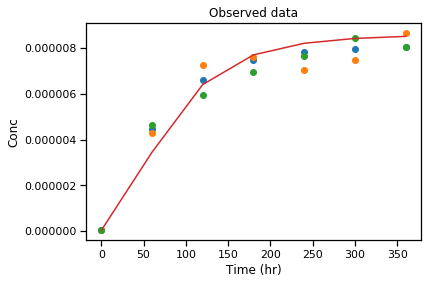

In [15]:
# Question 1b: 
def model_doubleEqn_Kmat(y, t, ind, params):
    mRNA  = y[0]
    prot  = y[1]
    protm = y[2]
    
    inducer = ind
    synm    = params[0]  
    k_ind   = params[1] 
    degm    = params[2] 
    synp    = params[3]
    kmature = params[4]
    mu      = params[5]
    
    dmRNA = synm*(inducer)/(inducer+k_ind)-degm*mRNA
    dprot = synp*mRNA - kmature*prot
    dprotm = kmature*prot - mu*protm
    
    return np.array([dmRNA, dprot, dprotm])

values1  = {'synm'   : 2e-5,  
            'k_ind'   : 12, 
            'degm'    : 0.2,  
            'synp'    : 0.01,
            'kmature' : 0.05,
            'mu'      : 0.015
          }

params     = list(values1.values())

y_init  = [0, 0, 2.5e-8]

inducer = 1

def get_SSE(tspan, y_data, inducer, params):
    model_data = odeint(model_doubleEqn_Kmat, y_init, tspan, args=tuple([inducer, params]))
    y_model    = model_data[:,2]
    
    SSE = 0
    for column in y_data:
        SSE += np.sum((y_data[column]-y_model)**2)
    
    return SSE


def objective_function_wrapper(tspan, y_data, inducer):
    def helper(params):
        return get_SSE(tspan, y_data, inducer, params)
    return helper

#This function now takes in the params as the sole argument and returns the SSE.
objective_function = objective_function_wrapper(tspan, y_data, inducer)


#Run optimizer.
result = basinhopping(objective_function, x0=params, niter=200, disp=True, 
                      take_step=take_step)
best_params = list(result.x)
print('Best optimized params:', result.x)


model_data = odeint(model_doubleEqn_Kmat, y_init, tspan, args=tuple([inducer, best_params]))
y_model    = model_data[:,2]

figQ1b = plt.figure()
axQ1b  = figQ1b.add_subplot(1,1,1)
axQ1b.plot(tspan, y_data,'o')
axQ1b.plot(tspan, y_model)
setting = axQ1b.set(title='Observed data', xlabel='Time (hr)', ylabel='Conc')

differential_evolution step 1: f(x)= 7.47215e-12
differential_evolution step 2: f(x)= 5.50689e-12
differential_evolution step 3: f(x)= 4.42641e-12
differential_evolution step 4: f(x)= 4.01274e-12
differential_evolution step 5: f(x)= 4.01274e-12
differential_evolution step 6: f(x)= 4.01274e-12
differential_evolution step 7: f(x)= 3.58658e-12
differential_evolution step 8: f(x)= 3.58658e-12
differential_evolution step 9: f(x)= 3.58658e-12
differential_evolution step 10: f(x)= 3.05739e-12
differential_evolution step 11: f(x)= 3.05739e-12
differential_evolution step 12: f(x)= 3.05739e-12
differential_evolution step 13: f(x)= 3.05739e-12
differential_evolution step 14: f(x)= 3.05739e-12
differential_evolution step 15: f(x)= 3.05739e-12
differential_evolution step 16: f(x)= 3.05739e-12
differential_evolution step 17: f(x)= 3.05739e-12
differential_evolution step 18: f(x)= 3.05739e-12
differential_evolution step 19: f(x)= 3.05739e-12
differential_evolution step 20: f(x)= 3.05739e-12
different

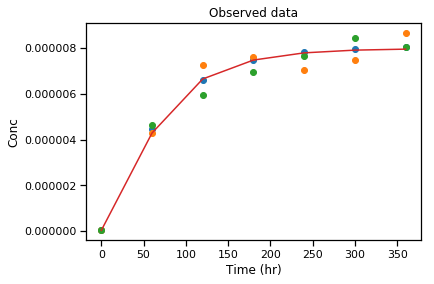

In [16]:
# Question 2 (based on the model_doubleEqn_Kmat)

from scipy.optimize import differential_evolution

bounds = {'synm'    : (1e-6,  1e-4),  
          'k_ind'   : (1,     20), 
          'degm'    : (0.1,   0.3),  
          'synp'    : (0.01,  0.1),
          'kmature' : (0.02, 0.1),
          'mu'      : (0.001, 0.03)
          }
bounds = np.array(list(bounds.values()))

result_de = differential_evolution(objective_function, bounds, disp=True)

best_params_new = list(result_de.x)
model_data = odeint(model_doubleEqn_Kmat, y_init, tspan, args=tuple([inducer, best_params_new]))
y_model    = model_data[:,2]

figQ2 = plt.figure()
axQ2  = figQ2.add_subplot(1,1,1)
axQ2.plot(tspan, y_data,'o')
axQ2.plot(tspan, y_model)
setting = axQ2.set(title='Observed data', xlabel='Time (hr)', ylabel='Conc')

#### Question 3

We use sum squared error instead of summing up the errors because a simple summation would result in negative and positive errors canceling out. As to why we square them instead of using the absolute, it is related to the concept of statistical variance. Details are beyond the scope of this project.

The optimizers in scipy are designed to search for the minimum of an objective function. If our objective function requires maximization, we can simply multiply it by -1; maximizing -x^2 gives the same result as minimizing x^2.

#### Question 4

Simulations do not always converge to the true parameters for a number of reasons:
1. Practical (un)identifiability
When the data is noisy, there will be many values of a parameter or multiple combinations of parameters that fit the data reasonably well. The remedy for this is higher quality data with narrow distribution.

2. Structural (un)identifiability
When multiple values of a parameter or multiple combinations of parameters can reproduce the exact same data, the parameter(s) are said to be structurally unidentifiable. 

An example is a sine wave; any integer value of n for sin(x + n * pi ) will give the exact same results. One thus cannot determine the value of n by looking at data generated by the shape of a sine wave. 

Another example is dx/dt = -a*b*x; a = 2 and b = 3 will give the same results as a=3 and b=2. One thus cannot determine the values of a and b by looking at the data generated by mesurements of x over time.

Yet another example is dx1/dt = -a*x1, dx2/dt = -b*x2, dx3/dt = -dx1/dt -dx2/dt where only x3 is measured and that the initial values for both x1 and x2 are equal.

Structural identifiability cannot be remedied by improving data quality since even perfect data would still result in multiple values/combinations of parameters fitting the data. Instead, one must either make changes to the model or experiment. For the last example, one could measure both x1 and x2 during the experiment. Alternatively, they could do a literature search to see if a or b have been determined by some other means and consider fixing the value of a or b to the value in the literature. If neither of these are possible, they then have to reformulate the model into a new set of equations.

In terms of their impact on the objective function, both structural and practical unidentifiability result in multiple local minima/maxima. Samplers can end up in different extrema depending on chance, the starting point for sampling as well as choice of sampler.

3. Sampler limitations
In some cases, the nature of the objective function may be so that the sampler is not suited for determining the maximum/minimum value. In most cases, changing the settings or using a different algorithm will suffice; changing the objective function is most unlikely.

Whether or not we really need to find the true values of the parameters depends on the goal of our analysis. For example, if we have a model that was fitted to a range of inducer concentrations 0, 0.2, 0.4, 0.6, 0.8 and 1, it is likely that it would be able to predict the response of the system at 0.9 inducer concentration even if the parameter values were different from the true values. The same cannot be said if we wanted to predict the system response with an inducer concentration of 2 or if the rbs was changed. The former case can be considered a case of interpolation, which is generally safe for local or empirical models while the latter can be thought of as a case of extrapolation which can be dangerous for said models.